## TA-14 — Simulating Logistics with SimPy
Antrean Drive-Thru Restoran Cepat Saji

Nama: Hilmi Nurpadilah

NIM: 301230004

Kelas: IF-5B

Notebook ini disusun sesuai ketentuan TA-14 Praktikum Pemodelan dan Simulasi, meliputi:
- Discrete Event Simulation (DES) menggunakan SimPy
- Pemodelan antrean mobil drive-thru
- Analisis performa sistem antrean
- What-If Analysis (1 kasir vs 2 kasir)
- Visualisasi dan dataset hasil simulasi

Satuan waktu simulasi: menit

## 1. Persiapan Lingkungan

Pada tahap ini dilakukan:
1. Import library yang dibutuhkan
2. Penentuan seed agar simulasi dapat direplikasi

In [1]:
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

## 2. Parameter Simulasi 

Parameter simulasi ditentukan berdasarkan rancangan TP-14:
- Entitas: Mobil
- Resource: Kasir drive-thru
- Inter-arrival time: Distribusi eksponensial (mean = 10 menit)
- Service time: Distribusi uniform (3–5 menit)
- Skenario A: 1 kasir
- Skenario B: 2 kasir

In [2]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

MEAN_INTERARRIVAL = 10.0
SERVICE_TIME_MIN = 3.0
SERVICE_TIME_MAX = 5.0

SIM_TIME = 600

CASHIERS_A = 1
CASHIERS_B = 2

## 3. Desain Model Simulasi 
3.1 Resource

Kasir dimodelkan sebagai simpy.Resource dengan kapasitas tertentu.

3.2 Proses Entitas (Mobil)
Alur mobil:
1. Datang ke sistem
2. Menunggu kasir (jika sibuk)
3. Dilayani
4. Keluar dari sistem

Setiap mobil dicatat untuk keperluan analisis.

In [3]:
def sample_interarrival(mean):
    return random.expovariate(1.0 / mean)

def sample_service_time(tmin, tmax):
    return random.uniform(tmin, tmax)

def car_process(env, car_id, cashier, records):
    arrival_time = env.now
    
    with cashier.request() as req:
        yield req
        start_service = env.now
        waiting_time = start_service - arrival_time
        
        service_time = sample_service_time(SERVICE_TIME_MIN, SERVICE_TIME_MAX)
        yield env.timeout(service_time)
        
        finish_time = env.now
    
    records.append({
        "car_id": car_id,
        "arrival_time": arrival_time,
        "start_service": start_service,
        "finish_time": finish_time,
        "waiting_time": waiting_time,
        "service_time": service_time,
        "system_time": finish_time - arrival_time
    })

## 4. Generator Kedatangan Mobil 

Generator akan menciptakan mobil secara terus-menerus dengan jarak kedatangan acak.

In [4]:
def car_generator(env, cashier, records, mean_interarrival):
    car_id = 0
    while True:
        car_id += 1
        env.process(car_process(env, car_id, cashier, records))
        yield env.timeout(sample_interarrival(mean_interarrival))   

## 5. Monitoring Panjang Antrean 
Untuk analisis tambahan, dilakukan pencatatan:

1. panjang antrean

2. jumlah kasir yang sedang melayani

Data ini digunakan untuk melihat bottleneck sistem terhadap waktu.

In [5]:
def monitor_queue(env, cashier, queue_log, interval=1.0):
    while True:
        queue_log.append({
            "time": env.now,
            "queue_length": len(cashier.queue),
            "in_service": cashier.count
        })
        yield env.timeout(interval)

## 6. Fungsi Runner Simulasi 

Fungsi ini menjalankan simulasi dan mengembalikan:

1. Data log mobil
2. Data log antrean
3. Ringkasan metrik performa

In [6]:
def run_simulation(num_cashiers, sim_time, seed=42):
    random.seed(seed)
    
    env = simpy.Environment()
    cashier = simpy.Resource(env, capacity=num_cashiers)
    
    records = []
    queue_log = []
    
    env.process(car_generator(env, cashier, records, MEAN_INTERARRIVAL))
    env.process(monitor_queue(env, cashier, queue_log))
    
    env.run(until=sim_time)
    
    df = pd.DataFrame(records)
    qdf = pd.DataFrame(queue_log)
    
    summary = {
        "num_cashiers": num_cashiers,
        "cars_processed": len(df),
        "avg_wait": df["waiting_time"].mean(),
        "max_wait": df["waiting_time"].max(),
        "avg_system": df["system_time"].mean(),
        "avg_queue_length": qdf["queue_length"].mean(),
        "max_queue_length": qdf["queue_length"].max()
    }
    
    return df, qdf, summary

## 7. Menjalankan Skenario A dan B

In [7]:
df_A, q_A, summary_A = run_simulation(CASHIERS_A, SIM_TIME, RANDOM_SEED)
df_B, q_B, summary_B = run_simulation(CASHIERS_B, SIM_TIME, RANDOM_SEED)

summary_table = pd.DataFrame([summary_A, summary_B])
summary_table

,num_cashiers,cars_processed,avg_wait,max_wait,avg_system,avg_queue_length,max_queue_length
0,1,56,1.523988,6.798333,5.459288,0.143333,2
1,2,50,0.095631,1.569288,3.968409,0.008333,1


## 8. Visualisasi

8.1 Line Chart - Waktu Tunggu Mobil

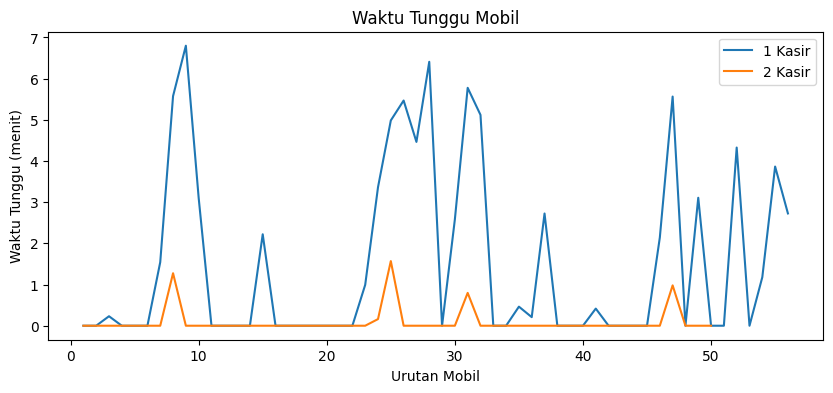

In [8]:
plt.figure(figsize=(10,4))
plt.plot(df_A["car_id"], df_A["waiting_time"], label="1 Kasir")
plt.plot(df_B["car_id"], df_B["waiting_time"], label="2 Kasir")
plt.xlabel("Urutan Mobil")
plt.ylabel("Waktu Tunggu (menit)")
plt.title("Waktu Tunggu Mobil")
plt.legend()
plt.show()

8.2 Total Waktu Dalam Sistem

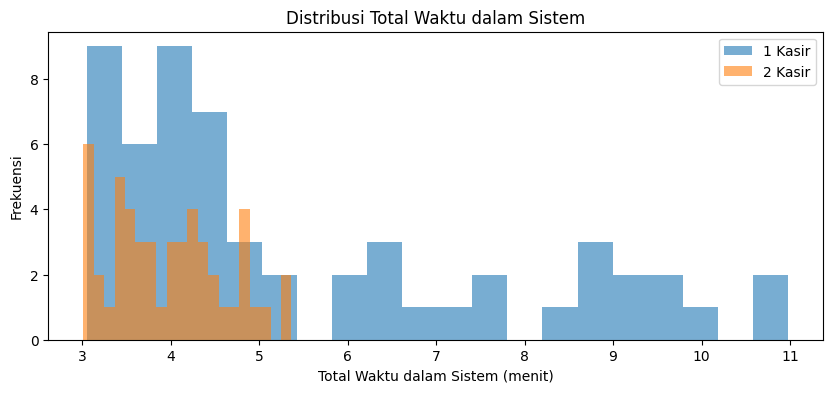

In [9]:
plt.figure(figsize=(10,4))
plt.hist(df_A["system_time"], bins=20, alpha=0.6, label="1 Kasir")
plt.hist(df_B["system_time"], bins=20, alpha=0.6, label="2 Kasir")
plt.xlabel("Total Waktu dalam Sistem (menit)")
plt.ylabel("Frekuensi")
plt.title("Distribusi Total Waktu dalam Sistem")
plt.legend()
plt.show()

8.3 Line Chart Panjang Antrean terhadap Waktu

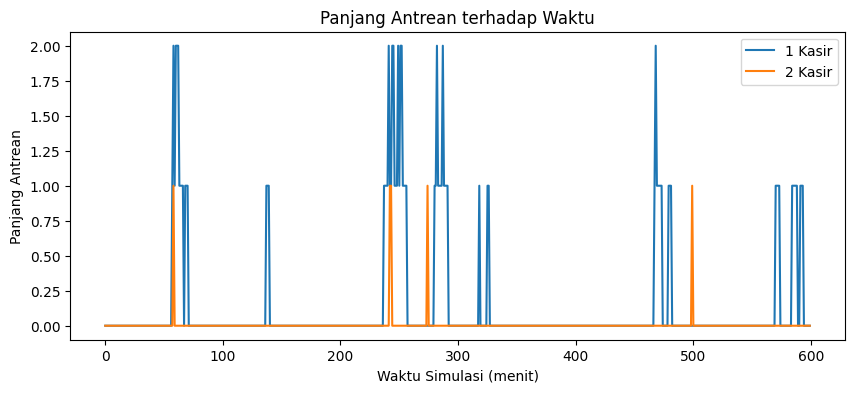

In [10]:
plt.figure(figsize=(10,4))
plt.plot(q_A["time"], q_A["queue_length"], label="1 Kasir")
plt.plot(q_B["time"], q_B["queue_length"], label="2 Kasir")
plt.xlabel("Waktu Simulasi (menit)")
plt.ylabel("Panjang Antrean")
plt.title("Panjang Antrean terhadap Waktu")
plt.legend()
plt.show()  

## 9. Kesimpulan
Simulasi menunjukkan bahwa:

Sistem dengan 2 kasir menghasilkan waktu tunggu dan panjang antrean yang lebih rendah

Penambahan resource efektif untuk mengurangi bottleneck

Model ini dapat digunakan sebagai dasar pengambilan keputusan operasional